In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from average_traces import AverageTraces
from Session import Session, SessionLite
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from matplotlib import gridspec
import seaborn as sns

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [3]:
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [4]:
## The AverageTraces class is currently the simplest way to get
## sessions, rename or something in future
at = AverageTraces('dff')
sessions = at.sessions
session = sessions[2]

In [5]:
def prepare_data(session, tp):

    frames_use = session.frames_use
    times_use = at.times_use
    
    assert len(frames_use) == len(times_use)
    
    frame_idx = frames_use[np.where(times_use == tp)[0]]
    X = np.squeeze(session.behaviour_trials[:,:,frame_idx])
    
    ##### WHAT YOU WAN DECODE? ####
    y = session.photostim
    idxs_use = np.where((y==0) | (y==1))[0]
    
    y = y[idxs_use]
    X = X[:, idxs_use]
    
    assert len(set(y)) == 2
    assert y.shape[0] == X.shape[1]
    
    # Get input matrix to (n_samples, n_features)
    X = X.T
    
    # demean and scale to unit varience
    scaler = sklearn.preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

In [6]:
def logistic_regression(X, y, penalty, reg_strength, solver, n_folds=5, return_models=False):
    
    results = []
    models = []

    folds = sklearn.model_selection.StratifiedKFold(n_splits=n_folds)
    
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = sklearn.linear_model.LogisticRegression(penalty=penalty, C=reg_strength, class_weight='balanced',
                                                        solver=solver)
        model.fit(X=X_train, y=y_train)

        models.append(model)
        results.append(model.score(X_test, y_test))

    if return_models:
        return models
    else:
        return np.mean(results), np.std(results)

Text(0.5, 1.0, 'L2 reg')

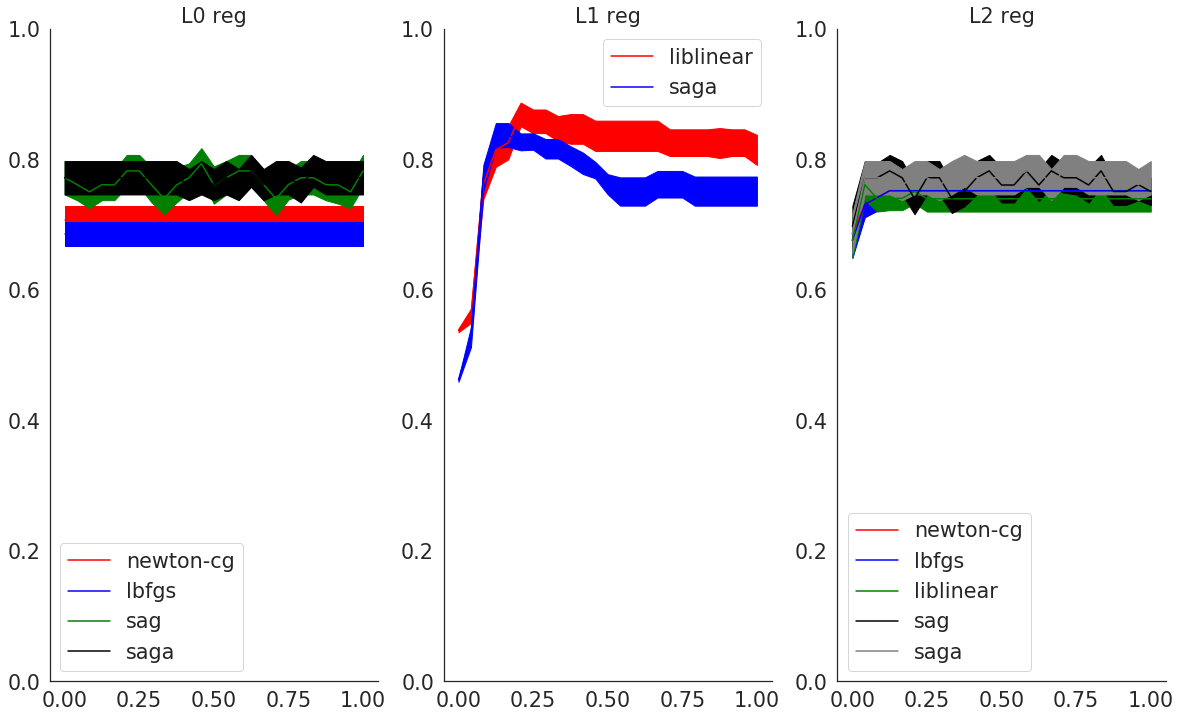

In [7]:
## Hand tune model parameters
X, y = prepare_data(session, 1)

plt.figure(figsize=(20,12))
reg_strengths = np.linspace(1e-5, 1, 25)
colors = ['red', 'blue', 'green', 'black', 'grey']

plt.subplot(1,3,1)
## Plotting reg strength for no regularisation doesnt make sense but can quickly eyeball the plot to compare
for idx, solver in enumerate(['newton-cg', 'lbfgs', 'sag', 'saga']):
    
    means = [] 
    stds = [] 
    
    for reg_strength in reg_strengths:

        mean_acc, std_acc = logistic_regression(X, y, 'none', 0, solver)
        means.append(mean_acc)
        stds.append(std_acc)
    
    means = np.array(means)
    stds = np.array(stds)
    sems = stds / 5
    plt.plot(reg_strengths, means, label=solver, color=colors[idx])
    plt.fill_between(reg_strengths, means-sems, means+sems, color=colors[idx])
    plt.ylim(0, 1)
    
plt.legend()
plt.title('L0 reg')

plt.subplot(1,3,2)
for idx, solver in enumerate(['liblinear', 'saga']):
    
    means = [] 
    stds = [] 
    
    for reg_strength in reg_strengths:

        mean_acc, std_acc = logistic_regression(X, y, 'l1', reg_strength, solver)
        means.append(mean_acc)
        stds.append(std_acc)
    
    means = np.array(means)
    stds = np.array(stds)
    sems = stds / 5
    plt.plot(reg_strengths, means, label=solver, color=colors[idx])
    plt.fill_between(reg_strengths, means-sems, means+sems, color=colors[idx])
    plt.ylim(0, 1)
    
plt.legend()
plt.title('L1 reg')

plt.subplot(1,3,3)
for idx, solver in enumerate(['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']):
    
    means = [] 
    stds = [] 
    
    for reg_strength in reg_strengths:

        mean_acc, std_acc = logistic_regression(X, y, 'l2', reg_strength, solver)
        means.append(mean_acc)
        stds.append(std_acc)
        
    means = np.array(means)
    stds = np.array(stds)
    sems = stds / 5
    plt.plot(reg_strengths, means, 'k-', label=solver, color=colors[idx])
    plt.fill_between(reg_strengths, means-sems, means+sems, color=colors[idx])
    
    plt.ylim(0, 1)
    
plt.legend()
plt.title('L2 reg')


In [10]:
# Best L1 result from the graph above
X, y = prepare_data(session, 1)
C = 0.2
solver = 'liblinear'
acc, _ = logistic_regression(X, y, 'l1', C, solver)
acc

0.8584795321637427

In [11]:
def n_cells_used(model, cell_bool=None):
    
    weights = np.squeeze(model.coef_)
    
    if cell_bool is None:
        return np.sum(weights!=0) / len(weights)
    else:
        #return np.sum(weights[cell_bool]!=0) / sum(cell_bool)
        return np.sum(weights[cell_bool]!=0) 

In [12]:
# Does it use the same cells?
def which_cells(model):
    weights = np.squeeze(model.coef_)
    print(np.where(weights!=0)[0])

In [8]:
s1 = []
s2 = []

times = at.times_use[::2]

C = 0.2
for tp in times:
    
    X, y = prepare_data(session, tp)
    models = logistic_regression(X, y, 'l1', C, solver, return_models=True)
    
    #[which_cells(model) for model in models]
    s1.append(
        [n_cells_used(model, session.s1_bool) for model in models]
             )
    
    s2.append(
        [n_cells_used(model, session.s2_bool) for model in models]
        
             )
    
s1 = np.array(s1)
s2 = np.array(s2)

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [9]:
mean = np.mean(s1, 1)
std = np.std(s1, 1)

plt.plot(times, mean, label='s1', color='blue')
plt.fill_between(times, mean-std, mean+std, color='blue')

mean = np.mean(s2, 1)
std = np.std(s2, 1)

plt.plot(times, mean, label='s2', color='red')
plt.fill_between(times, mean-std, mean+std, color='red')

plt.legend()

IndexError: tuple index out of range

In [10]:
C = 1
solver = 'lbfgs'

rankings = []

for tp in times:
    X, y = prepare_data(session, tp)
    ## Actually maybe it doesnt make sense to use Lasso to do RFE? use ridge?               
    estimator = sklearn.linear_model.LogisticRegression(penalty='l2', C=C, class_weight='balanced',
                                                        solver=solver)
    selector = RFE(estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X, y)
    rankings.append(selector.ranking_)
rankings = np.array(rankings)

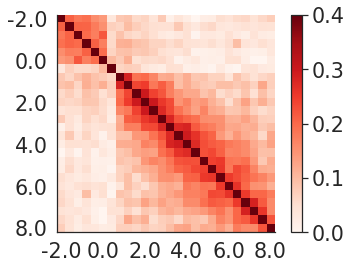

In [56]:
plt.imshow(np.corrcoef(rankings), cmap='Reds', vmin=0, vmax=0.4)

ticks = times[::5]
tick_pos = np.arange(len(rankings))[::5] 

plt.xticks(tick_pos, ticks)
plt.yticks(tick_pos, ticks)
plt.colorbar()


In [ ]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)